# BEFORE YOU START

Enter your names and group number and execute the following code cell:

Group member 1 name: 
Group member 2 name:  
Group member 3 name:  

In [1]:
GROUP_NUMBER = 7
GROUP_MEMBER_1_NAME = "Valeria Tazhdavletova"
GROUP_MEMBER_2_NAME= "Alberto Pitzalis"
GROUP_MEMBER_3_NAME = "Damian Monea"

In [2]:
# this code block MUST be executed before all the rest, also before the library imports!
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(GROUP_NUMBER)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.45
session = tf.Session(config=config)

# Deep Reinforcement Learning Project: Catching Orbs
Reinforcement Learning (RL) is a branch of machine learning that is focused on learning from interactions with the environment. Compared to supervised learning, where labeled examples are provided, and unsupervised learning, where the goal is to discover hidden structures in unlabeled data, RL distinguishes itself with three essential characteristics: 

1. there is a closed-loop interactive cycle between the agent and the environment, 
2. there are no clear instructions on how to behave and,
3. the goal is to maximize a reward signal distributed over an extended period. 

Learning from interaction is a foundational idea underlying the nature of learning, which makes it an fascinating research topic. In this notebook, we will introduce you to RL by means of training an agent to solve a small game. 

## The challenge: catching orbs with robots

The goal of this project is to provide hands-on experience with RL. During this project, you will learn when to use RL for a problem, how to tackle such a problem and how to think in terms of training an agent. This will help you recognize the hurdles associated with RL and how to diagnosis DQN and find improvements to faciltate learning.  

The most fun way to get acquainted with RL is by playing games, which is what we will do in this project. You will train an agent, in our setting a robot represented by a green triangle, to capture an orb. 

#### Level 1
In the following screenshot, you can see the first level of the game: 
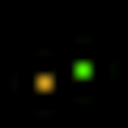
In this level, the robot operates in a 10x10 grid and can move in four directions: up, down, left, right. Once the robot touches the golden orb, he receives a point and the orb is respawned at a different location. The robot does not resemble a triangle here due to rescaling the 10x10 image.

#### Level 2
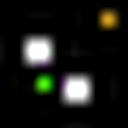
Level 2 operates on the same principles as level 1 with the two main differences. First, the robot now has two obstacles blocking the way towards the orb. The second difference is that when the robot touches both obstacles, a red bonus orb is spawned which is worth much more compared to the regular, golden orb. The bonus orb is removed when the robot catches it or in case the robot first captures the regular orb, the bonus orb is removed and the regular orb and obstacles respawned at different locations. 

#### Level 3
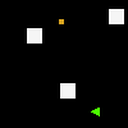
In level 3, we scale up the grid of the robot from 10x10 to 50x50 and introduce three obstacles. In case the robot touches all three obstacles, three bonus orbs are released randomly in to the grid. The same (re-)spawning rules as in level 2 apply. 


# Orb catching Environment
The standard way of defining an RL environment is following the specifications of the [OpenAI Gym environment](https://gym.openai.com/). An RL environment should contain following methods: 
- **Step**: the environment advances one step given a specified action and returns the new state, the reward of taking that step and whether the episode is finished. In our case, the state is represented by an RGB image, the reward is a scalar value and the episode is finished when the robot catches the orb. 
- **Reset**: the environment can be reset to a new state when the episode is finished
- **Render**: visualizes the state in the environment for debugging purposes
- **Close**: clean-up when you're done

Each of these methods are also present in the class 'OrbCatchingEnvironment' which we will use as wrapper for this game.

## Hello Orb Game
Run the following lines of code to see how the different levels of orb catching game works

In [3]:
# Some imports we will use across the notebook
import time
import random
import numpy as np 

from IPython.display import clear_output
import PIL 
from PIL import Image
from keras.layers import MaxPooling2D
from statistics import Statistics
from orb_catching_env import OrbCatchingEnvironment
from orb_catching_game.robot import Robot
from replay_buffer import ReplayBuffer
from policies import AnnealingEpsGreedyPolicy, RandomRepeatingPolicy, EpsGreedyPolicy
import logging
from logzero import logger, loglevel
from ipywidgets import interact, IntSlider

import math
import os
import types

loglevel(logging.INFO)
DISPLAY_SIZE = (128, 128)

Using TensorFlow backend.


In [5]:
def OrbCatchingGameDemo(level_of_game):
    env = OrbCatchingEnvironment(level=level_of_game)

    dur = 5
    start = time.time()
    while (time.time() - start) < dur:
        a = random.randint(0, 3)
        obs, reward, done, info = env.step(Robot.ACTIONS[a])
        if done:
            env.reset()
        img = env.render()
        time.sleep(0.3)
        clear_output(wait=True)

    env.reset()
    env.close()

In [6]:
interact(OrbCatchingGameDemo, level_of_game=IntSlider(min=1, max=3, step=1, value=1))

interactive(children=(IntSlider(value=1, description='level_of_game', max=3, min=1), Output()), _dom_classes=(…

<function __main__.OrbCatchingGameDemo(level_of_game)>

# The level of the game
For what follows we set the level to 1 (except when you are ready). When you get through the notebook and have an agent that can solve level 1, you will change this variable to 2 to start solving the next level.

In [4]:
level_of_game = 1

# Deep Q-learning
Deep Q-learning is an iterative regression procedure for calculating the Q-values of state-action pairs. This is done by letting the agent interact with the environment and backpropagating the loss between the estimated Q-value and the target Q-value. The target Q-value is calculated by taking the reward and the discounted future Q-values:

$Q_\mathrm{target} = r + \gamma \max\limits_{a'}Q(s',a';\theta^-)$

The two key features compared to tabular Q-learning which makes deep Q-learning works are (1) using a replay buffer and (2) using a target network to calculate the future Q-values. The **replay buffer** represents the memory of the agent. We sample random experiences from this buffer in order to *decorrelate* the data. The **target network** is used as an oracle to calculate the future Q-values. The weights are updated at a certain, slower frequency compared to the online network. This makes the data *more stationary* which is necessary for convergence.


## DQN ingredients
In the following sections of the notebook, you will define all necessary RL ingredients:
- the reward function
- exploration-exploitation trade-off by means of tuning the policy 
- the required preprocessing steps to help the agent in its learning process 
- the neural network archictecture, i.e. the brain of the agent
- debugging and diagnostics tools
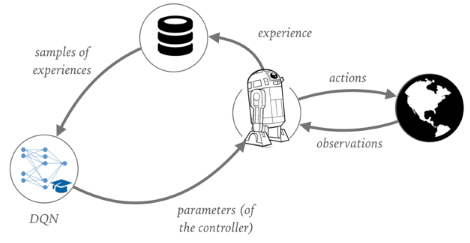

## Reward function
The premise of RL is that you have a reward function to guide an agent to optimal behavior in an unknown environment. This reward is given each time the agent takes an action in the environment. The reward helps up building the Q-value of a state-action pair. Note that the reward we receive from the environment is not the same as the Q-value. The Q-value is defined as the expected utility of taking action a in state s and acting optimally in the subsequent states.

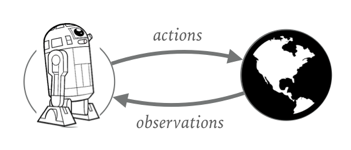

**TASK**:
Write a reward function that assign a reward of 10 when the robot catches the orb and gives a negative reward for wandering.
You can use following methods:
- game.normal_orb_is_caught(): returns True when the orb is caught, else False
- game.robot.position: returns the (x, y) position of the robot as a tuple
- game.normal_orb.position: returns the (x, y) position of the orb as a tuple
- game.n_bonus_orbs_collected: returns the amount of bonus orbs the robot has collected

In [5]:
class StaticVariable:
    val = 0

last_val = StaticVariable()
last_val.val = 0
def reward(game): 
    #reward_ = 0
    if game.normal_orb_is_caught() is True:
        return 100
    else:
        distance = np.sqrt(np.power(game.robot.position[0] - game.normal_orb.position[0],2) + np.power(game.robot.position[1] - game.normal_orb.position[1],2))
        if last_val.val > distance:
            last_val.val = distance
            return 1
        else:
            #f last_val.val is 0:
            last_val.val = distance
            return -1
           
        #print(aux-distance)
        #print(last_val.val)
        #time.sleep(0.5)
        return 0

**TASK**: Explain your decision process behind this reward function in the next cell.

As the task suggests, the function should return a value of 10 if the orb has been caught. Otherwise, we return a negative value as a penalty for the agent, for wandering. We chose the negative reward arbitrarily.

You can debug your reward function by running the next cell.

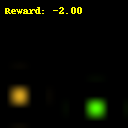

In [20]:
from PIL import Image, ImageDraw

env = OrbCatchingEnvironment(reward_function=reward, level=level_of_game)
env.render()

dur = 50
start = time.time()
while (time.time() - start) < dur:
    a = random.randint(0, 3)
    obs, r, done, info = env.step(Robot.ACTIONS[a])
        
    img = obs 
    img = PIL.Image.fromarray(img).resize(OrbCatchingEnvironment.DISPLAY_SIZE, Image.ANTIALIAS)

    d = ImageDraw.Draw(img)
    d.text((5,5), "Reward: {:0.2f}".format(r), fill=(255,255,0))
            
    display(img)
    clear_output(wait=True)
    time.sleep(0.1)
    
    if done:
        time.sleep(1.5)
        env.reset()

env.reset()
env.close()

## Policy
In order to learn how to take optimal actions in an environment, we need to both *explore* different actions to get to know the uncharted territory and *exploit* the gained knowledge to maximize the expected reward. This trade-off can be made by tuning the policy that decides which action to take, given a state. Traditionally, we define an *$\epsilon$-greedy policy* where there is a probability of $\epsilon$ that a random action is taken. Consequently, there is a probability of $1 - \epsilon$ of acting greedy, i.e. choosing the action that maximizes the Q-value of the given state. 

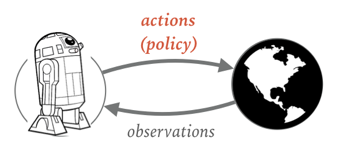

A logical way to implement this, is by varying $\epsilon$ across the learning stages of the agent. We start off with a high $\epsilon$, meaning that we allow the agent to act random in order to get to know the environment it is operating in. We gradually decrease $\epsilon$ in order to exploit the gained knowledge. 

As a side note, note that we will embed the brain of the agent, i.e. the neural network, inside of this policy. 

**TASK**: Think about a logical end-value of $\epsilon$ for the policy and fill it in the next cell.

In [6]:
epsilon_end_value = 0.1

**TASK**: Explain in the following cell the chosen end value of epsilon and how it will affect the RL agent.

We chose 0.1 because at first the movements are random and we want the robot to explore the world as much as possible. Afterwards, as it gains more knowledge, it will start taking the right steps, instead of random ones.

## Preprocessing
When the agent takes an action on the environment, it receives a reward and the new state. 
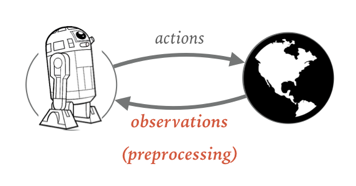
In our case, the environment returns RGB images. Feeding raw RGB images to the neural network of the agent leads to more weights that have to be trained, consequently increasing the required training time. It is for this reason we apply preprocessing on the input states. 

**TASK**: write a preprocessor in the method 'state_preprocessing' by changing the RGB images to grayscale.

In [13]:
'''
Preprocesses the input image.
Args: 
    state (np.ndarray): RGB image as numpy array with shape (10, 10, 3)
Returns:
    preprocessed_state (np.ndarray): preprocessed input image as numpy array
'''
image_shape = (10, 10)
n_channels = (1, )
preprocessing_output_shape = (image_shape + n_channels)

def state_preprocessing(state):
    img = Image.fromarray(state, mode='RGB')
    
    #Implement your preprocessing here
    aux = img.convert('L')
    img_as_array = np.array(aux)
    #img_as_array = (image_as_array + n_channels)
    img_as_array = np.reshape(img_as_array, (10, 10, 1))
    img_as_array[img_as_array == 172] = 255
    img_as_array[img_as_array == 165] = 255/2
    
    img_as_array= img_as_array.astype(np.float32)
    img_as_array/=255
    
    assert img_as_array.shape == preprocessing_output_shape
    
    return img_as_array

Run the following cell to examine the output of your preprocessing

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


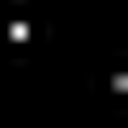

In [15]:
env = OrbCatchingEnvironment(level=level_of_game)

dur = 5
start = time.time()
while (time.time() - start) < dur:
    a = random.randint(0, 3)
    obs, r, done, info = env.step(Robot.ACTIONS[a])
    if done:
        time.sleep(1)
        env.reset()
    #print(obs)
    preprocessed_state = state_preprocessing(obs)
    mode = 'RGB' if preprocessed_state.shape[2] == 3 else 'L'
    print(np.around(preprocessed_state[:,:,0], 2))
    preprocessed_state = preprocessed_state * 255 if np.max(preprocessed_state) < 10 else preprocessed_state
    preprocessed_state = preprocessed_state.astype(np.uint8)
    display(PIL.Image.fromarray(preprocessed_state[:,:,0], mode=mode).resize(DISPLAY_SIZE, Image.ANTIALIAS))
    
    time.sleep(0.5)
    clear_output(wait=True)

env.reset()
env.close()

If you take any other preprocessing steps, explain why in the subsequent cell

explain here

## Deep Q network
The *deep* in deep reinforcement learning refers to representing the Q-value with a deep neural network. 

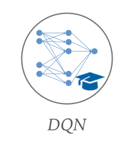

Define in the following cell a neural network using following design rules:
- Use no more than 2 convolutional layers and 1 fully-connected layer
- We recommend kernel sizes of (2, 2), (3, 3) and (4, 4) with stride 1 in both axes
- Use at maximum 64 filters in total
- Keep the amount of hidden units in the fully-connected layer between 128 and 1024.

In [16]:
from keras import Sequential
from keras.layers import Conv2D, Activation, Flatten, Dense
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import keras

model_input_shape = preprocessing_output_shape
model_output_shape = 4 # there are 4 actions the robot can take

def create_level_1_model():
    model = Sequential()
    
    # Implement your model here 
    
    model.add(Conv2D(32, (3,3), strides = (1,1), input_shape = model_input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (2,2), strides = (1,1)))
    keras.layers.BatchNormalization()
    #model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    
    model.add(Dense(model_output_shape,activation = 'softmax'))
    
    
    learning_rate = 0.00025
    model.compile(loss="mean_squared_error", optimizer=Adam(lr=learning_rate))

    print(model.summary())
    return model

create_level_1_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               803328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 809,828
Trainable params: 809,828
Non-trainable params: 0
_________________________________________________________________
None

**TASK**: Explain network choice

explain here  

## DQN algorithm
In the following lines of code, the DQN algorithm is implemented using the building blocks you defined above. You don't have to fill in anything in here. You are encouraged to read through the code while trying to understand everything is going on. 

In [17]:
class DQNAgent:
    def __init__(self, env, state_processing, nn_model, end_eps, **kwargs):

        #######################
        # DQN setup
        #######################
        self.env = env
        self.n_actions = env.action_space.n
        self.state_processing = state_processing
        self.input_shape = self.env.input_shape
        self.n_channels = 1

        replay_buffer_size = kwargs.get('replay_buffer_size', 100_000)
        self.replay_buffer = ReplayBuffer(size=replay_buffer_size)
        if kwargs.get('path_to_prev_buffer'):
            self.replay_buffer.load(kwargs.get('path_to_prev_buffer'))

        self.policy = AnnealingEpsGreedyPolicy(0.99, epsilon_end_value, 75_000, self, stochastic=False)
        self.test_policy = EpsGreedyPolicy(0.1)
        self.buffer_filling_policy = RandomRepeatingPolicy(1, self.env.action_space.n)

        #######################
        # Duration parameters
        #######################
        self.max_n_episodes = kwargs.get('max_n_episodes', np.inf)
        self.max_n_steps_per_eps = kwargs.get('max_n_steps_per_eps', 200)
        self.max_training_steps = kwargs.get('max_training_steps', 100_000)

        #######################
        # Network & training
        #######################
        self.n_steps_start_learning = 25_000 if not kwargs.get('path_to_prev_buffer') else 0
        self.discount_factor = 0.99

        self.action_value_network = nn_model
        self.target_network = nn_model
        if kwargs.get('path_to_prev_weights'):
            self.action_value_network = load_model(kwargs.get('path_to_prev_weights'))
            self.target_network = load_model(kwargs.get('path_to_prev_weights'))

        self.mini_batch_size = kwargs.get('mini_batch_size', 32)
        self.n_training_cycles = 0
        self.learning_frequency = 1  # 4 in atari
        self.n_replay_episodes = 1

        self.weight_persist_path = 'trained_models/'
        if not os.path.exists(self.weight_persist_path):
            os.makedirs(self.weight_persist_path)

        # --------------------------------------------------------------------------------
        # Target network update parameters
        self.tau = 0.001
        self.target_network_update_freq = kwargs.get('target_network_update_freq', 0.01 * self.replay_buffer.size)
        # --------------------------------------------------------------------------------

        # --------------------------------------------------------------------------------
        # Training hacks
        self.respawn_robot_each_n_episode = kwargs.get('respawn_robot_each_n_episode', 0)
        self.double_dqn = kwargs.get('double_dqn', False)
        # --------------------------------------------------------------------------------

        #######################
        # Bookkeeping values
        #######################
        self.n_steps = 0
        self.n_episodes = 0

        self.statistics = Statistics()
        self.log_itr = 0
        self.log_freq = kwargs.get('log_freq', 1)
        self.persist_weights_every_n_times_trained = 10e3

    @property
    def n_env_steps_made(self):
        return self.env.steps_taken
    
    
    # TODO: document, comments 
    def train(self, render=False, time_allowed=30 * 60):       
        start = time.time()
        time_elapsed = 0
        while self.n_episodes < self.max_n_episodes and (time_elapsed < time_allowed):
            logger.debug('Starting new episode')
            start_of_episode = time.time()
            episode_rewards = []
            training_errors = []

            self.env.reset()

            terminal = False
            steps_this_episode = 0
            while not terminal and steps_this_episode < self.max_n_steps_per_eps:
                state = self.env.state
                preprocessed_state = self.state_processing(state)
                action = self.act(preprocessed_state)
                next_state, reward, terminal, _ = self.env.step(action)
                
                steps_this_episode += 1

                # penalty when exceeding max amount of steps
                if steps_this_episode >= self.max_n_steps_per_eps:
                    reward = reward_when_exceeding_max_n_steps = -10 
                    terminal = True

                episode_rewards.append(reward)

                self.replay_buffer.add(preprocessed_state, action, reward, self.state_processing(next_state),
                                       terminal)

                if self._can_start_learning():
                    for i in range(self.n_replay_episodes):
                        training_error = self.q_learn_mini_batch(self.replay_buffer, self.action_value_network, self.target_network)
                        training_errors.append(training_error)
                        self._persist_weights_if_necessary()

                self.n_steps += 1

                if self.n_steps % self.target_network_update_freq == 1:
                    self.update_target_network()

                if render:
                    self.env.render()
    
            logline = self._make_logging_line(episode_rewards, start_of_episode, steps_this_episode, training_errors)
            self.statistics.log(logline)

            if self.n_episodes % self.log_freq == 0:
                log_msg = 'Episode nr {:d} took {:d} steps to capture {:d} orb(s).' \
                          'Epsilon is at {:0.3f}.' \
                          ' The agent received a total reward of {:.2f} and is making an average q-value prediction error of {:0.02f}.' \
                          ' The simulation runs at {:0.3f} seconds per step'.format(
                    logline['Episodes'], logline['Steps this episode'],logline['Orbs caught this episode']
                    ,logline['Epsilon'], logline['Total return'], logline['training_errors'], logline['Time needed per step']
                )
                
                logger.info(log_msg)

            self.n_episodes += 1

            time_elapsed = time.time() - start

        return self.statistics
    
    def act(self, preprocessed_state):
        if self.n_steps < self.n_steps_start_learning:
            action = self.buffer_filling_policy.get_action()
        else:
            action = self.policy.get_action(preprocessed_state, self.action_value_network)
            
        return action

    def q_learn_mini_batch(self, replay_buffer, action_value_network, target_network):
        logger.debug('Starting to train on mini-batch')
        self.n_training_cycles += 1

        # Sample a mini batch from our buffer
        mini_batch = replay_buffer.sample(self.mini_batch_size)

        # Extract states and subsequent states from mini batch
        states = np.array([sample[0] for sample in mini_batch])
        next_states = np.array([sample[3] for sample in mini_batch])

        # We predict the Q values for all current states in the batch using the online network to use as targets.
        # The Q values for the state-action pairs that are being trained on in the mini batch will be overridden with
        #       the real target r + gamma * argmax[Q(s', a); target network]
        online_q_values_current_states = targets = action_value_network.predict(states)

        # Predict all next Q values for the subsequent states in the batch using the target network
        # We do this beforehand for computational efficiency -> it is better to send data in batches to the GPU
        # instead of sample per sample
        target_q_values_next_states = target_network.predict(next_states)

        if self.double_dqn:
            online_q_values_next_states = action_value_network.predict(next_states)

        for sample_nr, transition in enumerate(mini_batch):
            state, action, reward, next_state, terminal = transition
            q_values = target_q_values_next_states[sample_nr].flatten()

            best_next_action = np.argmax(q_values) if not self.double_dqn \
                else np.argmax(online_q_values_next_states[sample_nr].flatten())

            # Insert real target value using r + gamma * argmax[Q(s', a); target network] if not terminal
            q_value_next_state = q_values[best_next_action]
            if terminal:
                # This is important as it gives you a stable, consistent reward which will not fluctuate (i.e. depend on the target network)
                targets[sample_nr, action] = reward
            else:
                targets[sample_nr, action] = reward + self.discount_factor * q_value_next_state

        training_loss = action_value_network.train_on_batch(states, targets)
        return training_loss

    def update_target_network(self):
        logger.info('Updating target network')
        weights = self.action_value_network.get_weights()
        target_weights = self.target_network.get_weights()

        update_hard = True
        if update_hard:
            self.target_network.set_weights(target_weights)
        else:
            for i in range(len(target_weights)):
                target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
            self.target_network.set_weights(target_weights)
            
    def test(self, render=False, episodes=100):
        test_statistics = Statistics()
        n_test_episodes = 0
        while n_test_episodes < episodes:
            episode_rewards = []

            self.env.reset()

            terminal = False
            steps_this_episode = 0
            while not terminal and steps_this_episode < self.max_n_steps_per_eps:
                state = self.env.state
                preprocessed_state = self.state_processing(state)
                action = self.test_policy.get_action(preprocessed_state, self.action_value_network)
                next_state, reward, terminal, _ = self.env.step(action)

                steps_this_episode += 1

                # penalty when exceeding max amount of steps
                if steps_this_episode >= self.max_n_steps_per_eps:
                    reward = -10
                    terminal = True

                episode_rewards.append(reward)

                self.n_steps += 1

                if render:
                    self.env.render()
                    time.sleep(0.5)
            
            n_test_episodes += 1 
            
            logline = self._make_logging_line(episode_rewards, np.NaN, steps_this_episode, np.NaN)
            test_statistics.log(logline)
            
            if self.n_episodes % self.log_freq == 0:
                log_msg = 'Test Episode nr {:d} took {:d} steps to capture {:d} orb(s).' \
                          'Epsilon is at {:0.3f}.' \
                          ' The agent received a total reward of {:.2f}'.format(
                    logline['Episodes'], logline['Steps this episode'], logline['Orbs caught this episode']
                    , logline['Epsilon'], logline['Total return']
                )

                logger.info(log_msg)

            self.n_episodes += 1
            
        return test_statistics

    def _can_start_learning(self):
        return self.n_steps > self.n_steps_start_learning and \
               self.n_steps % self.learning_frequency == 0 and \
               self.replay_buffer.n_obs > self.mini_batch_size

    def _make_logging_line(self, episode_rewards, start_of_episode, steps_this_episode, training_errors):
        logger.debug('Starting evaluation cycle')
        episode_return = sum(episode_rewards)
        discounted_episode_return = episode_rewards * self.discount_factor ** np.arange(len(episode_rewards))
        time_eps = time.time() - start_of_episode
        self.log_itr += 1
        logline = {}
        logline['Iteration'] = self.log_itr
        logline['Steps'] = self.n_steps
        logline['Steps this episode'] = steps_this_episode
        logline['Orbs caught this episode'] = self.env.orbs_caught
        logline['Epsilon'] = self.policy.current_eps_value
        logline['Episodes'] = self.n_episodes
        logline['Total return'] = episode_return
        logline['Average Return'] = np.mean(episode_rewards)
        logline['Average Discounted Return'] = np.mean(discounted_episode_return)
        logline['Total Discounted Return'] = np.sum(discounted_episode_return)
        logline['training_errors'] = np.mean(training_errors).tolist()
        logline['Time needed for this episode'] = time_eps
        logline['Time needed per step'] = time_eps / steps_this_episode
        
        return logline

    def _persist_weights_if_necessary(self):
        if self.n_training_cycles % self.persist_weights_every_n_times_trained == 0:
            logger.info('Saving network weights')
            path = '{}/model_level_{}.h5f'.format(self.weight_persist_path, self.env.level)
            self.action_value_network.save(path, overwrite=True)
            
            path = 'replay_buffers'
            if not os.path.exists(path):
                os.makedirs(path)
            file_path = os.path.join(path, 'replay_buffer_level_{}.pkl'.format(self.env.level))
            self.replay_buffer.persist(file_path)


## Running the agent
We can finally start training the agent. Launch the following cell to release the agent in the environment.

In [18]:
env = OrbCatchingEnvironment(reward_function=reward, level=level_of_game)
model = create_level_1_model()
agent = DQNAgent(env, state_preprocessing, model, end_eps=epsilon_end_value, log_freq=20)
stats = agent.train(render=False, time_allowed=90*60)

[I 180710 16:53:25 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               803328    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
Total params: 809,828
Trainable params: 809,828
Non-trainable params: 0
_________________________________________________________________
None

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[I 180710 16:53:26 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 0 took 90 steps to capture 1 orb(s).Epsilon is at 0.990. The agent received a total reward of 85.00 and is making an average q-value prediction error of nan. The simulation runs at 0.004 seconds per step
[I 180710 16:53:26 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:53:26 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 20 took 32 steps to capture 1 orb(s).Epsilon is at 0.990. The agent received a total reward of 87.00 and is making an average q-value prediction error of nan. The simulation runs at 0.000 seconds per step
[I 180710 16:53:26 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 18

[I 180710 16:53:35 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 440 took 77 steps to capture 1 orb(s).Epsilon is at 0.990. The agent received a total reward of 92.00 and is making an average q-value prediction error of nan. The simulation runs at 0.000 seconds per step
[I 180710 16:53:35 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:53:50 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:53:52 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 460 took 79 steps to capture 1 orb(s).Epsilon is at 0.976. The agent received a total reward of 80.00 and is making an average q-value prediction error of 47.26. The simulation runs at 0.011 seconds per step
[I 180710 16:53:59 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 480 took 58 steps to capture 1 orb(s).Epsilon is at 0.969. The agent received a total reward of 87.00 and is making an average q-value prediction error of 30.98. The simulation runs at 0.012 seconds per step
[I 180710 16:54:0

[I 180710 16:57:09 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:57:13 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 920 took 17 steps to capture 1 orb(s).Epsilon is at 0.760. The agent received a total reward of 100.00 and is making an average q-value prediction error of 77.13. The simulation runs at 0.011 seconds per step
[I 180710 16:57:20 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 940 took 83 steps to capture 1 orb(s).Epsilon is at 0.753. The agent received a total reward of 82.00 and is making an average q-value prediction error of 58.63. The simulation runs at 0.011 seconds per step
[I 180710 16:57:20 <ipython-input-17-b6e0c5d1caf4>:279] Saving network weights
[I 180710 16:57:21 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:57:26 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 960 took 16 steps to capture 1 orb(s).Epsilon is at 0.748. The agent received a total reward of 99.00 and is making an average q-value predicti

[I 180710 16:59:21 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 1440 took 3 steps to capture 1 orb(s).Epsilon is at 0.626. The agent received a total reward of 100.00 and is making an average q-value prediction error of 25.74. The simulation runs at 0.012 seconds per step
[I 180710 16:59:24 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 1460 took 29 steps to capture 1 orb(s).Epsilon is at 0.623. The agent received a total reward of 92.00 and is making an average q-value prediction error of 71.62. The simulation runs at 0.011 seconds per step
[I 180710 16:59:25 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 16:59:27 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 1480 took 17 steps to capture 1 orb(s).Epsilon is at 0.620. The agent received a total reward of 98.00 and is making an average q-value prediction error of 77.16. The simulation runs at 0.011 seconds per step
[I 180710 16:59:31 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 1500 took 4 steps to capt

[I 180710 17:00:50 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2000 took 19 steps to capture 1 orb(s).Epsilon is at 0.534. The agent received a total reward of 96.00 and is making an average q-value prediction error of 68.86. The simulation runs at 0.011 seconds per step
[I 180710 17:00:52 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2020 took 4 steps to capture 1 orb(s).Epsilon is at 0.531. The agent received a total reward of 101.00 and is making an average q-value prediction error of 57.60. The simulation runs at 0.012 seconds per step
[I 180710 17:00:55 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2040 took 7 steps to capture 1 orb(s).Epsilon is at 0.529. The agent received a total reward of 100.00 and is making an average q-value prediction error of 88.14. The simulation runs at 0.012 seconds per step
[I 180710 17:00:56 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 17:00:57 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2060 took 6 steps to capt

[I 180710 17:02:01 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2560 took 7 steps to capture 1 orb(s).Epsilon is at 0.460. The agent received a total reward of 102.00 and is making an average q-value prediction error of 65.84. The simulation runs at 0.012 seconds per step
[I 180710 17:02:04 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2580 took 10 steps to capture 1 orb(s).Epsilon is at 0.458. The agent received a total reward of 97.00 and is making an average q-value prediction error of 61.75. The simulation runs at 0.011 seconds per step
[I 180710 17:02:05 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 17:02:06 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2600 took 9 steps to capture 1 orb(s).Epsilon is at 0.455. The agent received a total reward of 102.00 and is making an average q-value prediction error of 34.38. The simulation runs at 0.011 seconds per step
[I 180710 17:02:08 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 2620 took 13 steps to cap

[I 180710 17:03:04 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 17:03:05 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3120 took 2 steps to capture 1 orb(s).Epsilon is at 0.397. The agent received a total reward of 101.00 and is making an average q-value prediction error of 115.82. The simulation runs at 0.012 seconds per step
[I 180710 17:03:06 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3140 took 2 steps to capture 1 orb(s).Epsilon is at 0.395. The agent received a total reward of 99.00 and is making an average q-value prediction error of 115.04. The simulation runs at 0.012 seconds per step
[I 180710 17:03:08 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3160 took 6 steps to capture 1 orb(s).Epsilon is at 0.393. The agent received a total reward of 97.00 and is making an average q-value prediction error of 77.01. The simulation runs at 0.012 seconds per step
[I 180710 17:03:11 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3180 took 26 steps to cap

[I 180710 17:03:58 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3700 took 1 steps to capture 1 orb(s).Epsilon is at 0.343. The agent received a total reward of 100.00 and is making an average q-value prediction error of 229.93. The simulation runs at 0.010 seconds per step
[I 180710 17:04:00 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3720 took 39 steps to capture 1 orb(s).Epsilon is at 0.341. The agent received a total reward of 98.00 and is making an average q-value prediction error of 116.21. The simulation runs at 0.012 seconds per step
[I 180710 17:04:02 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3740 took 4 steps to capture 1 orb(s).Epsilon is at 0.339. The agent received a total reward of 101.00 and is making an average q-value prediction error of 57.65. The simulation runs at 0.012 seconds per step
[I 180710 17:04:04 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 3760 took 2 steps to capture 1 orb(s).Epsilon is at 0.338. The agent received a total reward of 99.00 a

[I 180710 17:04:46 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4280 took 9 steps to capture 1 orb(s).Epsilon is at 0.296. The agent received a total reward of 100.00 and is making an average q-value prediction error of 187.79. The simulation runs at 0.012 seconds per step
[I 180710 17:04:48 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4300 took 6 steps to capture 1 orb(s).Epsilon is at 0.294. The agent received a total reward of 101.00 and is making an average q-value prediction error of 166.89. The simulation runs at 0.012 seconds per step
[I 180710 17:04:49 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4320 took 1 steps to capture 1 orb(s).Epsilon is at 0.293. The agent received a total reward of 100.00 and is making an average q-value prediction error of 76.92. The simulation runs at 0.010 seconds per step
[I 180710 17:04:51 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4340 took 7 steps to capture 1 orb(s).Epsilon is at 0.291. The agent received a total reward of 102.00 

[I 180710 17:05:35 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4860 took 6 steps to capture 1 orb(s).Epsilon is at 0.249. The agent received a total reward of 99.00 and is making an average q-value prediction error of 179.07. The simulation runs at 0.012 seconds per step
[I 180710 17:05:37 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4880 took 2 steps to capture 1 orb(s).Epsilon is at 0.248. The agent received a total reward of 101.00 and is making an average q-value prediction error of 76.77. The simulation runs at 0.011 seconds per step
[I 180710 17:05:38 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4900 took 4 steps to capture 1 orb(s).Epsilon is at 0.246. The agent received a total reward of 99.00 and is making an average q-value prediction error of 77.14. The simulation runs at 0.013 seconds per step
[I 180710 17:05:40 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 4920 took 3 steps to capture 1 orb(s).Epsilon is at 0.245. The agent received a total reward of 100.00 and

[I 180710 17:06:14 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 5440 took 3 steps to capture 1 orb(s).Epsilon is at 0.211. The agent received a total reward of 100.00 and is making an average q-value prediction error of 51.29. The simulation runs at 0.012 seconds per step
[I 180710 17:06:16 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 5460 took 2 steps to capture 1 orb(s).Epsilon is at 0.209. The agent received a total reward of 99.00 and is making an average q-value prediction error of 154.14. The simulation runs at 0.013 seconds per step
[I 180710 17:06:17 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 5480 took 2 steps to capture 1 orb(s).Epsilon is at 0.208. The agent received a total reward of 99.00 and is making an average q-value prediction error of 115.07. The simulation runs at 0.013 seconds per step
[I 180710 17:06:18 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 5500 took 2 steps to capture 1 orb(s).Epsilon is at 0.207. The agent received a total reward of 101.00 an

[I 180710 17:06:50 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 6020 took 4 steps to capture 1 orb(s).Epsilon is at 0.175. The agent received a total reward of 99.00 and is making an average q-value prediction error of 153.77. The simulation runs at 0.010 seconds per step
[I 180710 17:06:52 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 6040 took 7 steps to capture 1 orb(s).Epsilon is at 0.174. The agent received a total reward of 100.00 and is making an average q-value prediction error of 87.74. The simulation runs at 0.011 seconds per step
[I 180710 17:06:54 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 6060 took 8 steps to capture 1 orb(s).Epsilon is at 0.172. The agent received a total reward of 103.00 and is making an average q-value prediction error of 153.72. The simulation runs at 0.011 seconds per step
[I 180710 17:06:54 <ipython-input-17-b6e0c5d1caf4>:191] Updating target network
[I 180710 17:06:55 <ipython-input-17-b6e0c5d1caf4>:133] Episode nr 6080 took 8 steps to cap

KeyboardInterrupt: 

**TASK**: while your model is running, go to [this notebook](Diagnostics and visualizations.ipynb) to see how the network is doing!

## Evaluating the learned behavior
After training, it is time to examine what the agent has learned. Run the next cell to take a look at the learned behavior. 

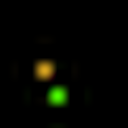

In [ ]:
path_trained_model = 'trained_models/model_level_{}.h5f'.format(level_of_game)
agent = DQNAgent(OrbCatchingEnvironment(reward_function=reward, level=level_of_game), state_preprocessing, None, end_eps=epsilon_end_value, log_freq=10, path_to_prev_weights=path_trained_model)
stats = agent.test(render=True, episodes=100)

print('Average collected reward over test episodes: {:0.2f}'.format(np.mean(stats.average_reward_per_episode)))
print('Average steps needed per episode: {:0.2f}'.format(np.mean(stats.steps_needed_per_episode)))

### Benchmarking the learned behavior
RL is often criticized for taking a very long to converge. For this reason, we will benchmark our DQN agent with a contestor: the random agent. The random agent chooses, obviously, a random action each step in the episode.

In [ ]:
path_trained_model = 'trained_models/model_level_{}.h5f'.format(level_of_game)
random_agent = DQNAgent(OrbCatchingEnvironment(reward_function=reward, level=level_of_game), state_preprocessing, None, 
                        end_eps=epsilon_end_value, log_freq=10, path_to_prev_weights=path_trained_model)

random_agent.test_policy = EpsGreedyPolicy(1)
stats_random_agent = random_agent.test(render=False, episodes=100)

print('Average collected reward over test episodes: {:0.2f}'.format(np.mean(stats_random_agent.average_reward_per_episode)))
print('Average steps needed per episode: {:0.2f}'.format(np.mean(stats_random_agent.steps_needed_per_episode)))

**TASK**: Analyse the performance difference between the random agent and the RL agent in the next cell

IT'S WORKIIING!!! :D


## Move on to level 2 and 3
Satisfied with your results for level 1? Set the level_of_game variable to 2 or 3 and edit the notebook tasks to the new game level.

A tip for the next levels: the agent of level 1 has learned some very relevant features for solving level 2 of the game. This might make in interesting to warm-start your network (i.e. the brain of the agent) with the weights of level 1. You can do this  like demonstrated in the previous cell: add a variable 'path_to_prev_weights' to the constructor of the DQNAgent class.

**Don't overwrite your answers for level 1 of the game when analyzing level 2.**